In [642]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import datetime
import matplotlib.pyplot as plt


# Loading and preparing data

### Load raport files

Get file names

In [643]:
# Define the possible values for NumberOfThreads, NameOfTest, and TypeOfReport
number_of_threads = ["2000", "1000", "500", "250", "100", "25", "50", "10"]
name_of_test = ["CalculateGPA", "GetTeachers", "HomeworkUpload", "TaskDownload"]
types_of_report = ["AggregateReport", "PerfMon"]
types_of_app = ["Net", "Node", "LBNode"]
base_folder_path = "C:/Studia/Praca Magisterska/apache-jmeter-5.5/bin/Results/"

def get_folder_files():
    # Create an empty list to store the files
    files = []

    # Iterate over each app type
    for app in types_of_app:
        # Define the folder path based on the app type
        folder_path = os.path.join(base_folder_path, app)

        # List all the files in the folder
        app_files = os.listdir(folder_path)

        # Add the app files to the list
        files.extend(app_files)

    return files

Make a dictionary with 4 properties (NumberOfThreads, App, NameOfTest, TypeOfReport)

In [644]:
def load_dataframes(files):
    # Create an empty dictionary to store the dataframes
    dataframes = {}
    types_of_properties = ["NumberOfThreads", "App", "NameOfTest", "TypeOfReport"]

    # Iterate over each file
    for file_name in files:
        # Remove the file extension (.csv)
        file_name_without_extension = os.path.splitext(file_name)[0]
    
        # Create a dictionary to hold the property values
        properties = {
            "NumberOfThreads": None,
            "App": None,
            "NameOfTest": None,
            "TypeOfReport": None
        }

        # Iterate over each possible property and find the corresponding value
        remaining_part = file_name_without_extension
        found = 0
        for prop_list in [number_of_threads, types_of_app, name_of_test, types_of_report]:
            prop_type = types_of_properties[found]
            for prop in prop_list:
                if remaining_part.startswith(prop):
                    # Found a matching property value
                    properties[prop_type] = prop
                    remaining_part = remaining_part[len(prop):].strip()
                    break
            found = found + 1

        # Check if all properties have been found
        if len(properties) == 4:
            # Create the file path based on the app value and base folder path
            app_val = properties["App"]
            app_folder_path = os.path.join(base_folder_path, app_val)
            file_path = os.path.join(app_folder_path, file_name)

            # Open the file using pandas and store it with properties in the dictionary
            df = pd.read_csv(file_path)
            dataframes[file_name] = (df, properties)

    return dataframes

Load .Net Core and Node results

In [645]:
files = get_folder_files()
dataframes = load_dataframes(files)


How to access specific dataframe

In [646]:
# Accessing a specific dataframe by key and accessing its properties
key = "100NetCalculateGPAAggregateReport.csv"
if key in dataframes:
    df, properties = dataframes[key]
    print("DataFrame Properties:")
    print("NumberOfThreads:", properties["NumberOfThreads"])
    print("App:", properties["App"])
    print("NameOfTest:", properties["NameOfTest"])
    print("TypeOfReport:", properties["TypeOfReport"])
    print("\nDataFrame:")
    # Display the dataframe
    #display(df)

DataFrame Properties:
NumberOfThreads: 100
App: Net
NameOfTest: CalculateGPA
TypeOfReport: AggregateReport

DataFrame:


### Prepare data

Remove columns with only 1 unique value and print their name: value

In [647]:
def remove_columns_with_single_value(dataframes):
    # Create a dictionary to store unique column values for each type of report
    unique_columns = {}

    # Iterate through the report types
    for report_type in types_of_report:
        print("Report Type:", report_type)

        # Get the dataframes for the current report type
        report_dataframes = [
            (key, (df, properties)) for key, (df, properties) in dataframes.items()
            if properties["TypeOfReport"] == report_type
        ]

        # Skip the report type if there are no dataframes available
        if not report_dataframes:
            continue

        # Track the deleted columns for the current report type
        deleted_columns = []

        # Retrieve the column names from the first dataframe of the report type
        column_names = report_dataframes[0][1][0].columns

        # Iterate through the columns of the dataframe
        for column in column_names:
            # Check if the column exists in all dataframes of the report type
            if all(column in df.columns for _, (df, _) in report_dataframes):
                # Check if the column has only one unique value in all dataframes of the report type
                if all(df[column].nunique() == 1 for _, (df, _) in report_dataframes):
                    # Store the column name in the deleted_columns list
                    deleted_columns.append(column)

        # Delete the columns with only one unique value from each dataframe of the report type
        for _, (df, _) in report_dataframes:
            df.drop(columns=deleted_columns, inplace=True)

        # Print the deleted columns for the current report type
        if deleted_columns:
            print("Deleted Columns:")
            for column in deleted_columns:
                print(column)
            print("---------------------------------------")

    return dataframes

In [648]:
dataframes = remove_columns_with_single_value(dataframes)

Report Type: AggregateReport
Deleted Columns:
label
dataType
URL
IdleTime
---------------------------------------
Report Type: PerfMon
Deleted Columns:
grpThreads
allThreads
---------------------------------------


Remove local IP from label column in the perfmon raports

In [649]:
def remove_substring_from_label(dataframes):
    for key, (df, properties) in dataframes.items():
        if properties["TypeOfReport"] == "PerfMon":
            df['label'] = df['label'].str.replace('192.168.1.204 ', '')
            dataframes[key] = (df, properties)
    return dataframes

In [650]:
dataframes = remove_substring_from_label(dataframes)

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/1313328991.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['label'] = df['label'].str.replace('192.168.1.204 ', '')


Divide values in the "Elapsed" column for the PerfMon raports by 1000 so that the value represents a percentage usage of CPU or Memory

In [651]:
def divide_elapsed_by_1000(dataframes):
    # Iterate over the dataframes
    for df_key, (df, properties) in dataframes.items():
        # Check if the report is of type "PerfMon"
        if properties["TypeOfReport"] == "PerfMon":
            # Divide the values in the "elapsed" column by 1000
            df["elapsed"] = df["elapsed"] / 1000

    return dataframes

In [652]:
dataframes = divide_elapsed_by_1000(dataframes)

Print head/describe

In [653]:
def display_dataframes_head_or_description(head_or_description_flag, dataframes):
    # Iterate through the report types
    for report_type in types_of_report:
        print("---------------------------------------")
        print("Report Type:", report_type)

        # Iterate through the thread numbers
        for thread_number in number_of_threads:
            print("Thread Number:", thread_number)

            # Iterate through the app types
            for app_type in types_of_app:
                print("---------------------------------------")
                print("App Type:", app_type)

                # Iterate through the dataframes for the current report type, thread number, and app type
                for key, (df, properties) in dataframes.items():
                    if (properties["TypeOfReport"] == report_type and
                            properties["NumberOfThreads"] == thread_number and
                            properties["App"] == app_type):
                        print("DataFrame:", key)
                        if head_or_description_flag:
                            display(df.head(2))
                        else:
                            display(df.describe())

In [654]:
#display_dataframes_head_or_description(1, dataframes)

Change timestamps to datetime

In [655]:
def convert_timestamp_to_datetime(dataframes):
    # Iterate through the dataframes in the dictionary
    for key, (df, properties) in dataframes.items():
        if "timeStamp" in df.columns:
            df["timeStamp"] = pd.to_datetime(df["timeStamp"], unit='ms')
    
    return dataframes

In [656]:
dataframes = convert_timestamp_to_datetime(dataframes)

# Comparison graphs and tables

### Compare amount of samples

In [657]:
def compare_row_counts(dataframes):
    # Initialize an empty list to store the comparison data
    comparison_data = []

    # Iterate through the dataframes dictionary
    for key, (df, properties) in dataframes.items():
        # Check if the type of report is "AggregateReport"
        if properties["TypeOfReport"] == "AggregateReport":
            # Get the number of threads and app type
            number_of_threads = properties["NumberOfThreads"]
            app_type = properties["App"]
            
            # Get the row count
            row_count = len(df)

            # Append the comparison data
            comparison_data.append({
                "Test": properties["NameOfTest"],
                "Number of Threads": number_of_threads,
                "Amount of Samples": row_count,
                "Type of App": app_type
            })

    # Create a DataFrame from the comparison data
    samples_df = pd.DataFrame(comparison_data)

    return samples_df

In [658]:
samples_df = compare_row_counts(dataframes)
display(samples_df)

,Test,Number of Threads,Amount of Samples,Type of App
0,CalculateGPA,1000,8456,Net
1,GetTeachers,1000,7792,Net
2,HomeworkUpload,1000,5568,Net
3,TaskDownload,1000,3754,Net
4,CalculateGPA,100,8906,Net
5,GetTeachers,100,7530,Net
6,HomeworkUpload,100,4921,Net
7,TaskDownload,100,4124,Net
8,CalculateGPA,10,5871,Net
9,GetTeachers,10,5035,Net


In [659]:
def create_sample_amount_comparison_graphs(df_comparison, test_name):
    # Filter the DataFrame for the specified test name
    filtered_df = df_comparison[df_comparison['Test'] == test_name]

    # Convert the 'Number of Threads' column to numeric type
    filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])

    # Sort the DataFrame by the 'Number of Threads' column in ascending order
    filtered_df = filtered_df.sort_values('Number of Threads')

    # Set the plot style
    sns.set(style="whitegrid")

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Number of Threads', y='Amount of Samples', hue='Type of App', data=filtered_df,
                     dodge=True, ci=None, hue_order=types_of_app)

    # Set the axis labels and title
    ax.set_xlabel("Liczba użytkowników")
    ax.set_ylabel("Liczba zapytań")
    ax.set_title(f"Porównanie liczby próbek dla testu {test_name}")

    # Display the value of each bar on top
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Show the legend
    ax.legend(title="Aplikacja")

    # Show the plot
    plt.show()


C:\Users\neros\AppData\Local\Temp/ipykernel_3676/1871765557.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


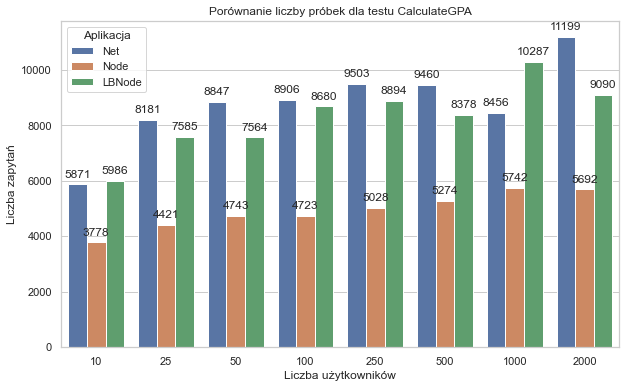

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/1871765557.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


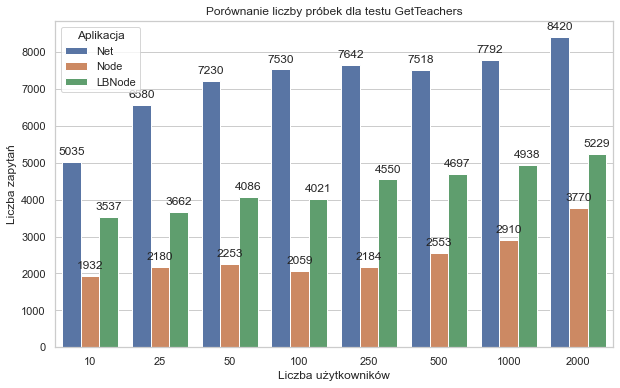

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/1871765557.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


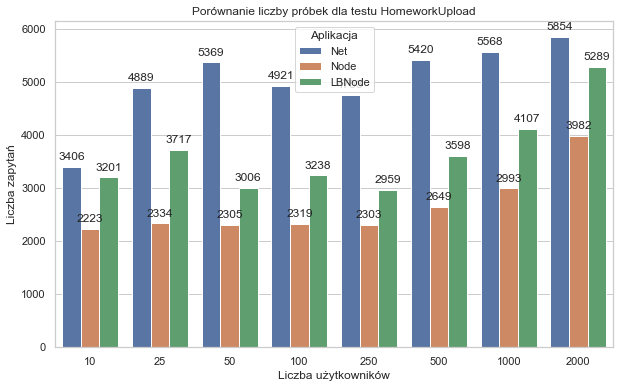

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/1871765557.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


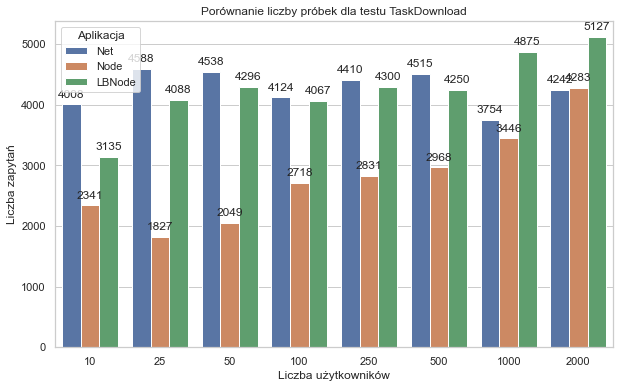

In [660]:
create_sample_amount_comparison_graphs(samples_df, name_of_test[0])
create_sample_amount_comparison_graphs(samples_df, name_of_test[1])
create_sample_amount_comparison_graphs(samples_df, name_of_test[2])
create_sample_amount_comparison_graphs(samples_df, name_of_test[3])

#### Large graph

Create a combined graph

In [661]:
# Join the "Test" and "Number of Threads"
samples_merged_df = samples_df.copy()
samples_merged_df['Number of Threads'] = samples_merged_df['Number of Threads'].astype(str)
samples_merged_df['Test'] = samples_merged_df['Test'] + ' (' + samples_merged_df['Number of Threads'] + ')'
samples_merged_df.drop('Number of Threads', axis=1, inplace=True)

In [662]:
def create_sample_amount_comparison_graphs(df_comparison):
    # Filter the DataFrame to exclude rows with "HomeworkUpload" in the Test column
    filtered_df = df_comparison[~df_comparison['Test'].str.contains('HomeworkUpload')]

    # Sort the DataFrame alphabetically by the "Test" column
    filtered_df = filtered_df.sort_values('Test')

    # Set the plot style
    sns.set(style="whitegrid")

    # Create a bar plot
    plt.figure(figsize=(18, 6))
    ax = sns.barplot(x='Test', y='Amount of Samples', hue='Type of App', data=filtered_df,
                     dodge=True, ci=None, hue_order=types_of_app)

    # Set the axis labels and title
    ax.set_ylabel("Ilość próbek")

    # Display the value of each bar on top
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Rotate x-axis labels for better readability
    #plt.xticks(rotation=90)

    # Show the legend
    ax.legend(title="Type of App")

    # Show the plot
    plt.show()

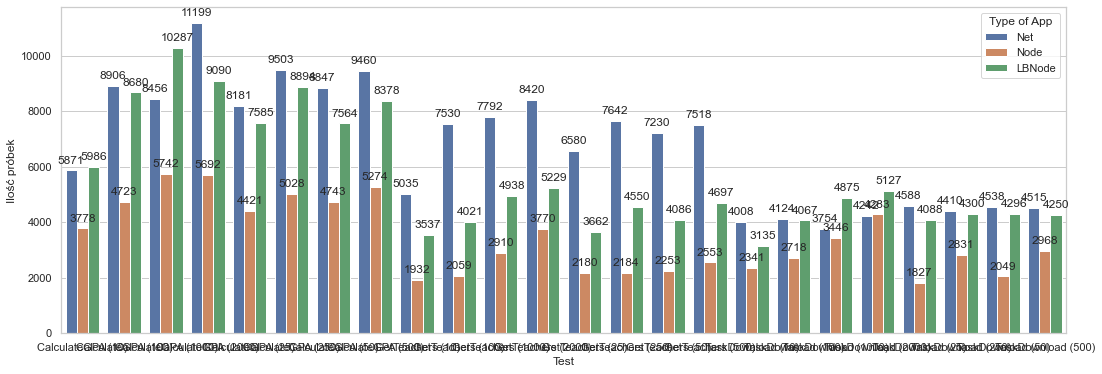

In [663]:
create_sample_amount_comparison_graphs(samples_merged_df)

### Compare the duration

Create a duration dataframe (calculates duration of specified test)

In [664]:
def create_duration_dataframe(dataframes):
    # Initialize an empty list to store the comparison data
    comparison_data = []

    # Iterate through the dataframes dictionary
    for key, (df, properties) in dataframes.items():
        # Check if the type of report is "AggregateReport"
        if properties["TypeOfReport"] == "AggregateReport":
            # Get the number of threads and app type
            number_of_threads = properties["NumberOfThreads"]
            app_type = properties["App"]

            # Calculate the duration based on the minimum and maximum timestamp
            min_timestamp = df["timeStamp"].min()
            max_timestamp = df["timeStamp"].max()
            duration = max_timestamp - min_timestamp

            # Append the comparison data
            comparison_data.append({
                "Test": properties["NameOfTest"],
                "Number of Threads": number_of_threads,
                "Duration": duration,
                "Type of App": app_type
            })

    # Create a DataFrame from the comparison data
    df_comparison = pd.DataFrame(comparison_data)

    return df_comparison

In [665]:
duration_df = create_duration_dataframe(dataframes)
display(duration_df)

,Test,Number of Threads,Duration,Type of App
0,CalculateGPA,1000,0 days 00:00:09.927000,Net
1,GetTeachers,1000,0 days 00:00:09.946000,Net
2,HomeworkUpload,1000,0 days 00:00:09.743000,Net
3,TaskDownload,1000,0 days 00:00:09.911000,Net
4,CalculateGPA,100,0 days 00:00:09.917000,Net
5,GetTeachers,100,0 days 00:00:09.918000,Net
6,HomeworkUpload,100,0 days 00:00:09.928000,Net
7,TaskDownload,100,0 days 00:00:09.918000,Net
8,CalculateGPA,10,0 days 00:00:09.933000,Net
9,GetTeachers,10,0 days 00:00:09.925000,Net


Create duration graph

In [666]:
def create_duration_comparison_graphs(duration_df, test_name):
    # Filter the DataFrame for the specified test name
    filtered_df = duration_df[duration_df['Test'] == test_name]

    # Convert the "Number of Threads" column to numeric
    filtered_df["Number of Threads"] = filtered_df["Number of Threads"].astype(int)

    # Convert the "Duration" column to numeric in milliseconds
    filtered_df["Duration"] = filtered_df["Duration"].dt.total_seconds() * 1000

    # Set the plot style
    sns.set(style="whitegrid")

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Number of Threads', y='Duration', hue='Type of App', data=filtered_df,
                     dodge=True, ci=None, hue_order=types_of_app)

    # Set the axis labels and title
    ax.set_xlabel("Number of Threads")
    ax.set_ylabel("Duration (ms)")
    ax.set_title(f"Duration Comparison for {test_name}")

    # Display the value of each bar on top
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Show the legend
    ax.legend(title="Type of App")

    # Show the plot
    plt.show()

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/1324470707.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Number of Threads"] = filtered_df["Number of Threads"].astype(int)
C:\Users\neros\AppData\Local\Temp/ipykernel_3676/1324470707.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Duration"] = filtered_df["Duration"].dt.total_seconds() * 1000


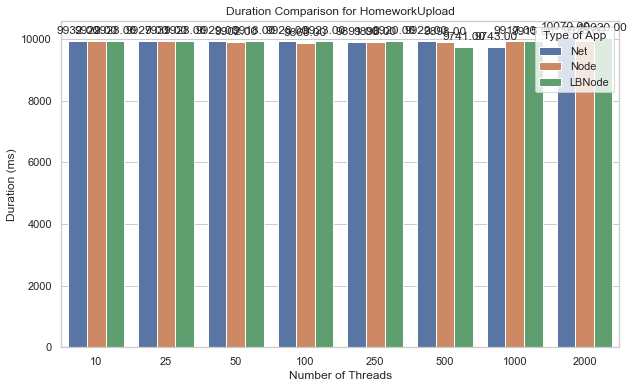

In [667]:
create_duration_comparison_graphs(duration_df, name_of_test[2])

Add duration column to PerfMon

In [668]:
def convert_timestamp_to_duration(dataframes):
    # Iterate through the dataframes in the dictionary
    for key, (df, properties) in dataframes.items():
        if properties["TypeOfReport"] == "PerfMon" and "timeStamp" in df.columns:
            # Convert the timestamp column to datetime
            df["timeStamp"] = pd.to_datetime(df["timeStamp"], unit='ms')
            
            # Calculate the duration column
            df["duration"] = (df["timeStamp"] - df["timeStamp"].min()) / pd.Timedelta(seconds=1)
    
    return dataframes

In [669]:
dataframes = convert_timestamp_to_duration(dataframes)

In [670]:
#display_dataframes_head_or_description(1, {key: value for key, value in dataframes.items() if value[1]["TypeOfReport"] == "PerfMon"})

### Compare throughput (samples per second)

Calculate the throughput

In [671]:
def calculate_throughput(duration_df, samples_df):
    # Merge duration_df and samples_df on Test and Number of Threads columns
    merged_df = pd.merge(duration_df, samples_df, on=['Test', 'Number of Threads', 'Type of App'])
    
    # Convert the Duration column to seconds
    merged_df['Duration'] = merged_df['Duration'].dt.total_seconds()
    
    # Calculate the throughput (samples per second)
    merged_df['Throughput'] = merged_df['Amount of Samples'] / merged_df['Duration']
    
    # Create the throughput_df with the desired columns
    throughput_df = merged_df[['Test', 'Number of Threads', 'Throughput', 'Type of App']]
    
    return throughput_df

In [672]:
throughput_df = calculate_throughput(duration_df, samples_df)
pd.set_option('display.max_rows', None)
display(throughput_df.sort_values(by='Test'))

,Test,Number of Threads,Throughput,Type of App
0,CalculateGPA,1000,851.818273,Net
24,CalculateGPA,500,953.821335,Net
28,CalculateGPA,50,893.726639,Net
32,CalculateGPA,1000,577.782250,Node
36,CalculateGPA,100,476.829884,Node
84,CalculateGPA,25,763.846928,LBNode
40,CalculateGPA,10,381.500555,Node
44,CalculateGPA,2000,565.243297,Node
48,CalculateGPA,250,506.650544,Node
52,CalculateGPA,25,445.800141,Node


Oblicz średnią, minimum, maksimum i odchylenie standardowe

In [673]:
def calculate_stats_by_app(dataframe, column_name):
    # Group the dataframe by "Type of App"
    grouped_df = dataframe.groupby("Type of App")
    
    # Calculate the statistics for the specified column
    stats_df = grouped_df[column_name].agg(["mean", "min", "max", "std"])
    
    return stats_df


In [674]:
stats = calculate_stats_by_app(throughput_df[throughput_df['Test'] == 'GetTeachers'], "Throughput")
display(stats.sort_values(by='Type of App'))

,mean,min,max,std
Type of App,,,,
LBNode,436.654456,356.265109,521.232057,60.180997
Net,726.969829,507.304786,846.231156,102.544147
Node,250.069499,194.718807,377.641991,60.211710


Create a graph

In [675]:
def create_throughput_comparison_graphs(df_comparison, test_name):
       # Filter the DataFrame for the specified test name
    filtered_df = df_comparison[df_comparison['Test'] == test_name]

    # Convert the 'Number of Threads' column to numeric type
    filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])
   
    # Set the plot style
    sns.set(style="whitegrid")

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Number of Threads', y='Throughput', hue='Type of App', data=filtered_df,
                     dodge=True, ci=None, hue_order=types_of_app)

    # Set the axis labels and title
    ax.set_xlabel("Liczba użytkowników")
    ax.set_ylabel("Przepustowość")
    ax.set_title(f"Porównanie przepustowości dla {test_name}")

    # Display the value of each bar on top
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Show the legend
    ax.legend(title="Aplikacja")

    # Show the plot
    plt.show()

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/1644156739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


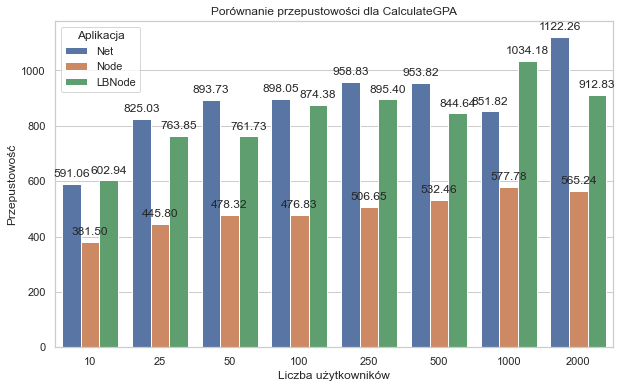

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/1644156739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


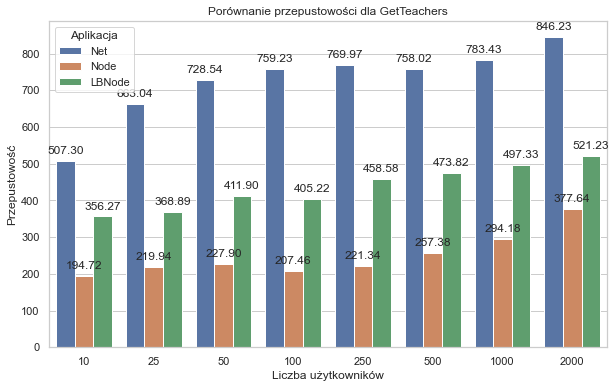

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/1644156739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


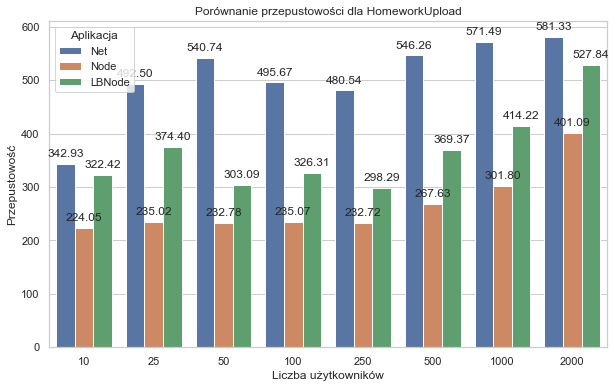

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/1644156739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


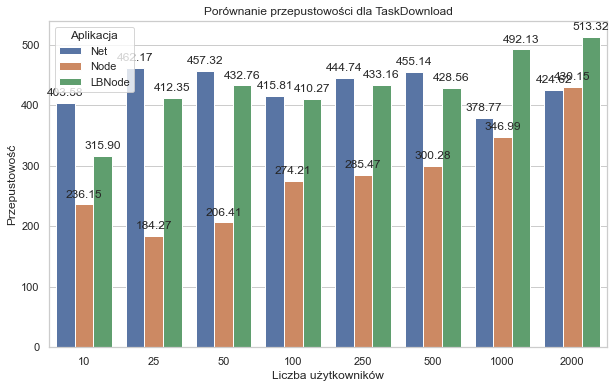

In [676]:
create_throughput_comparison_graphs(throughput_df, name_of_test[0])
create_throughput_comparison_graphs(throughput_df, name_of_test[1])
create_throughput_comparison_graphs(throughput_df, name_of_test[2])
create_throughput_comparison_graphs(throughput_df, name_of_test[3])

Create a combined graph

In [677]:
throughput_merged_df = throughput_df.copy()
throughput_merged_df['Number of Threads'] = throughput_merged_df['Number of Threads'].astype(str)
throughput_merged_df['Test'] = throughput_merged_df['Test'] + ' (' + throughput_merged_df['Number of Threads'] + ')'
throughput_merged_df.drop('Number of Threads', axis=1, inplace=True)

#### Large graph

In [678]:
def create_throughput_comparison_graphs(df_comparison):

    # Sort the DataFrame alphabetically by the "Test" column
    df_comparison = df_comparison.sort_values('Test')

    # Set the plot style
    sns.set(style="whitegrid")

    # Create a bar plot
    plt.figure(figsize=(24, 6))
    ax = sns.barplot(x='Test', y='Throughput', hue='Type of App', data=df_comparison,
                     dodge=True, ci=None, hue_order=types_of_app)

    # Set the axis labels and title
    ax.set_ylabel("Amount of samples")

    # Display the value of each bar on top
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Rotate x-axis labels for better readability
    #plt.xticks(rotation=90)

    # Show the legend
    ax.legend(title="Type of App")

    # Show the plot
    plt.show()

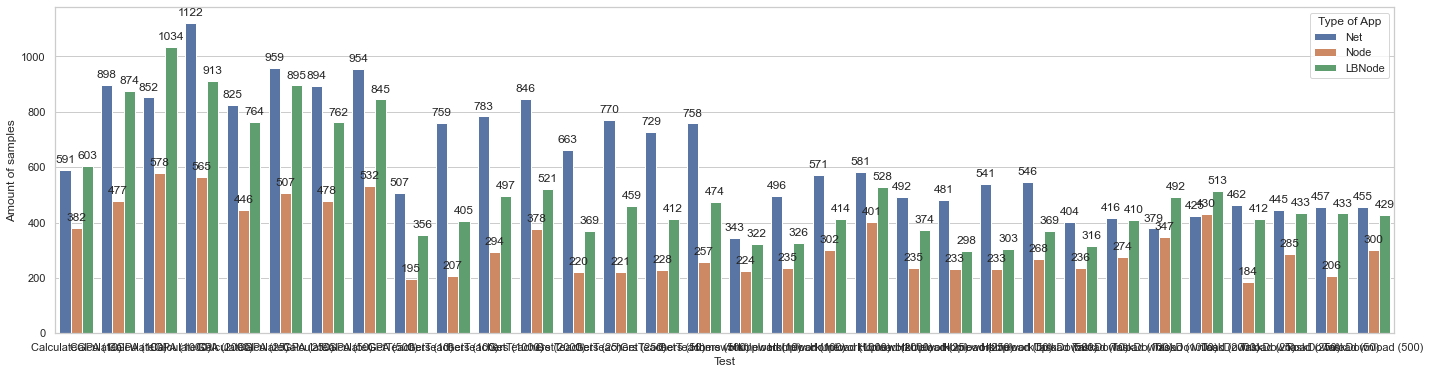

In [679]:
create_throughput_comparison_graphs(throughput_merged_df)

### Compare average CPU and Memory

Find earliest timestamp so that the avg cpu and mem usage is calculated after the test has started.

In [680]:
def find_earliest_and_latest_timestamp(dataframes):
    # Create an empty dataframe to store the results
    result_df = pd.DataFrame(columns=["Test", "Number of Threads", "Earliest TimeStamp", "Latest TimeStamp", "Type of App"])

    # Iterate over the dataframes
    for df_key, (df, properties) in dataframes.items():
        # Check if the report is of type "AggregateReport"
        if properties["TypeOfReport"] == "AggregateReport":
            # Find the earliest and latest timestamps in the "timeStamp" column
            earliest_timestamp = df["timeStamp"].min()
            latest_timestamp = df["timeStamp"].max()

            # Create a new row with the extracted values
            new_row = {
                "Test": properties["NameOfTest"],
                "Number of Threads": properties["NumberOfThreads"],
                "Earliest TimeStamp": earliest_timestamp,
                "Latest TimeStamp": latest_timestamp,
                "Type of App": properties["App"]
            }

            # Append the new row to the result dataframe
            result_df = result_df.append(new_row, ignore_index=True)

    return result_df

In [681]:
#display(find_earliest_timestamp(dataframes))

Calculate the average CPU and Memory for every test

In [682]:
def calculate_average_perfmon(dataframes, earliest_latest_timestamp_df):
    # Create a new dataframe to store the results
    result_df = pd.DataFrame(columns=["Test", "Number of Threads", "avgCPU", "avgMem", "Type of App"])

    # Iterate over the dataframes
    for df_key, (df, properties) in dataframes.items():
        # Check if the report is of type "PerfMon"
        if properties["TypeOfReport"] == "PerfMon":
            # Extract the relevant properties
            test_name = properties["NameOfTest"]
            number_of_threads = properties["NumberOfThreads"]
            app_type = properties["App"]

            # Find the corresponding timestamps from earliest_timestamp_df
            timestamp_row = earliest_latest_timestamp_df[
                (earliest_latest_timestamp_df["Test"] == test_name) &
                (earliest_latest_timestamp_df["Number of Threads"] == number_of_threads) &
                (earliest_latest_timestamp_df["Type of App"] == app_type)
            ]
            earliest_timestamp = timestamp_row["Earliest TimeStamp"].values[0]
            latest_timestamp = timestamp_row["Latest TimeStamp"].values[0]

            # Filter the rows in the dataframe based on the condition
            filtered_df = df[(df["timeStamp"] > earliest_timestamp) & (df["timeStamp"] < latest_timestamp)]

            # Calculate the average CPU and Memory values
            cpu_df = filtered_df[filtered_df["label"] == "CPU"]
            avg_cpu = cpu_df["elapsed"].mean()

            mem_df = filtered_df[filtered_df["label"] == "Memory"]
            avg_mem = mem_df["elapsed"].mean()

            # Create a new row with the extracted values
            new_row = {
                "Test": test_name,
                "Number of Threads": number_of_threads,
                "avgCPU": avg_cpu,
                "avgMem": avg_mem,
                "Type of App": app_type
            }

            # Append the new row to the result dataframe
            result_df = result_df.append(new_row, ignore_index=True)

    return result_df


In [683]:
earliest_timestamps_df = find_earliest_and_latest_timestamp(dataframes)
results_df = calculate_average_perfmon(dataframes, earliest_timestamps_df)
display(results_df.sort_values(by=["Test", "Number of Threads"]))


,Test,Number of Threads,avgCPU,avgMem,Type of App
8,CalculateGPA,10,57.122778,24.482333,Net
40,CalculateGPA,10,24.169300,25.418800,Node
72,CalculateGPA,10,66.441300,29.071000,LBNode
4,CalculateGPA,100,67.717333,25.962000,Net
36,CalculateGPA,100,27.134400,25.601300,Node
68,CalculateGPA,100,83.481556,29.363111,LBNode
0,CalculateGPA,1000,59.240200,27.590300,Net
32,CalculateGPA,1000,25.993000,25.811900,Node
64,CalculateGPA,1000,85.488556,29.839444,LBNode
12,CalculateGPA,2000,64.462111,32.117889,Net


In [684]:
def create_avg_comparison_graph(dataframe, test_name, use_cpu=True):
    # Filter the dataframe for the specified test name
    filtered_df = dataframe[dataframe['Test'] == test_name]

    # Convert the 'Number of Threads' column to numeric type
    filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])
        
    # Set the plot style
    sns.set(style="whitegrid")

    # Select the column for the y-values based on use_cpu argument
    y_column = 'avgCPU' if use_cpu else 'avgMem'

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Number of Threads', y=y_column, hue='Type of App', data=filtered_df,
                     ci=None, hue_order=types_of_app)

    # Set the y-axis limits
    if use_cpu:
        ax.set_ylim(0, 101)
    else:
        ax.set_ylim(0, 50)

    # Set the axis labels and title
    ax.set_xlabel("Liczba użytkowników")
    if use_cpu:
        ax.set_ylabel("Średnie zużycie CPU")
    else:
        ax.set_ylabel("Średnie zużycie RAM")
    
    if use_cpu:
        ax.set_title(f"Porównanie średniej zużycia procesora dla testu {test_name}")
    else:
        ax.set_title(f"Porównanie średniej zużycia RAM dla testu {test_name}")

    # Display the value of each bar on top
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Show the legend
    ax.legend(title="Typ aplikacji")

    # Show the plot
    plt.show()

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/3239356963.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


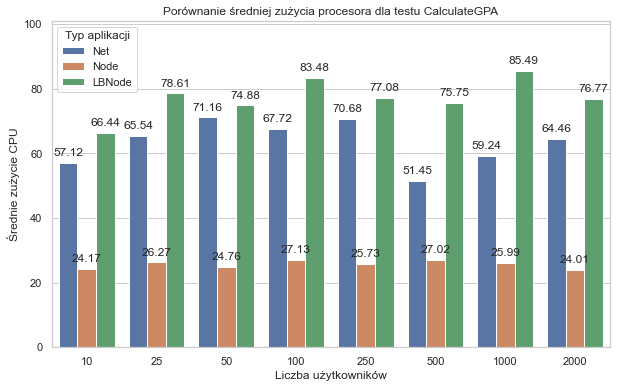

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/3239356963.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


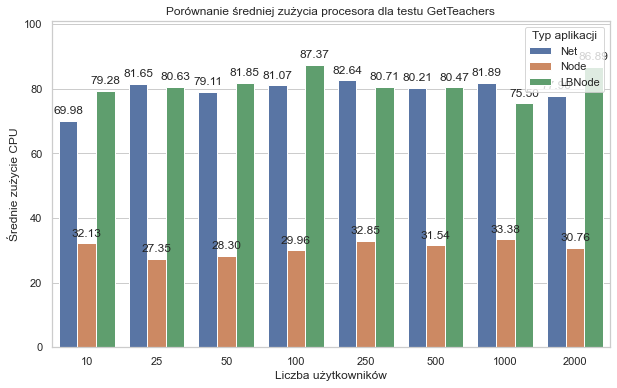

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/3239356963.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


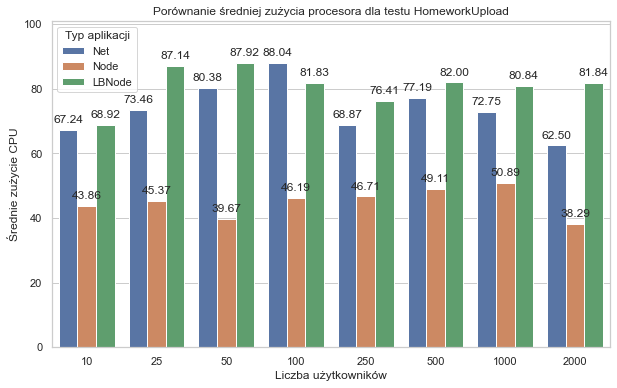

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/3239356963.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


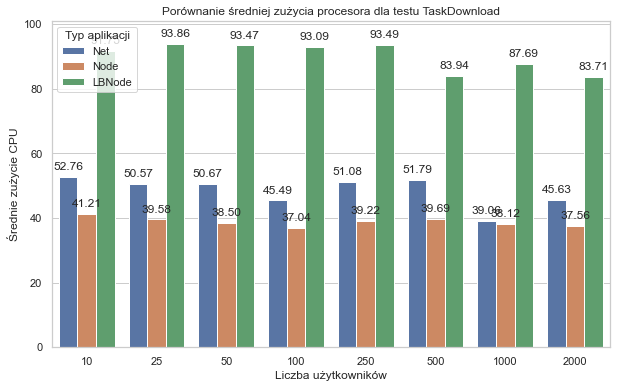

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/3239356963.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


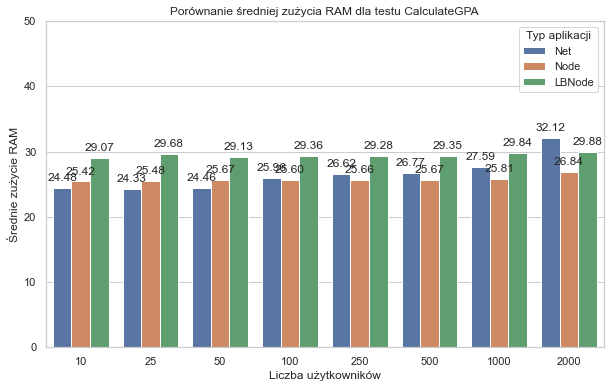

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/3239356963.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


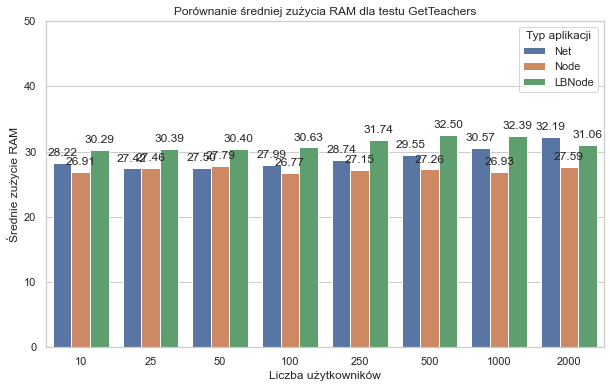

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/3239356963.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


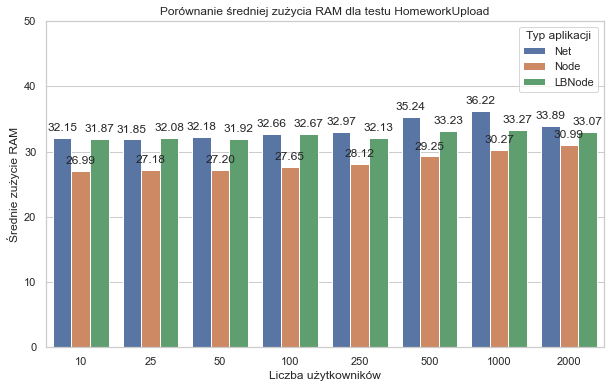

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/3239356963.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


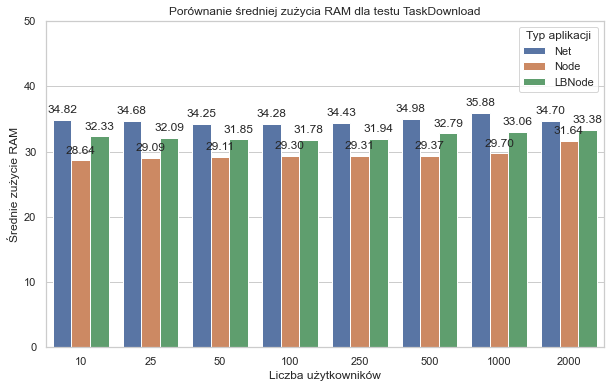

In [685]:
create_avg_comparison_graph(results_df, name_of_test[0])
create_avg_comparison_graph(results_df, name_of_test[1])
create_avg_comparison_graph(results_df, name_of_test[2])
create_avg_comparison_graph(results_df, name_of_test[3])

print("==================")

create_avg_comparison_graph(results_df, name_of_test[0], False)
create_avg_comparison_graph(results_df, name_of_test[1], False)
create_avg_comparison_graph(results_df, name_of_test[2], False)
create_avg_comparison_graph(results_df, name_of_test[3], False)

##### Large graph

Make a larger graph with all tests

In [686]:
def create_avg_comparison_graph_large(dataframe, use_cpu=True):
    # Join the values of the Test and Number of Threads columns
    dataframe['TestNumberThreads'] = dataframe['Test'] + " - " + dataframe['Number of Threads'].astype(str)

    # Sort the dataframe by the TestNumberThreads column in alphabetical order
    dataframe = dataframe.sort_values(by='TestNumberThreads')

    # Set the plot style
    sns.set(style="whitegrid")

    # Select the column for the y-values based on the use_cpu argument
    y_column = 'avgCPU' if use_cpu else 'avgMem'

    # Create a bar plot
    plt.figure(figsize=(18, 6))
    ax = sns.barplot(x='TestNumberThreads', y=y_column, hue='Type of App', data=dataframe,
                     dodge=True, ci=None, order=dataframe['TestNumberThreads'].unique(), hue_order=types_of_app)

    # Set the y-axis limits
    ax.set_ylim(0, 101)

    # Set the axis labels and title
    if use_cpu:
        ax.set_ylabel("avgCPU")
    else:
        ax.set_ylabel("avgMem")

    if use_cpu:
        ax.set_title("Average CPU Usage Comparison")
    else:
        ax.set_title("Average Memory Usage Comparison")

    # Display the value of each bar on top
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)

    # Show the legend
    ax.legend(title="Type of App")

    # Show the plot
    plt.show()


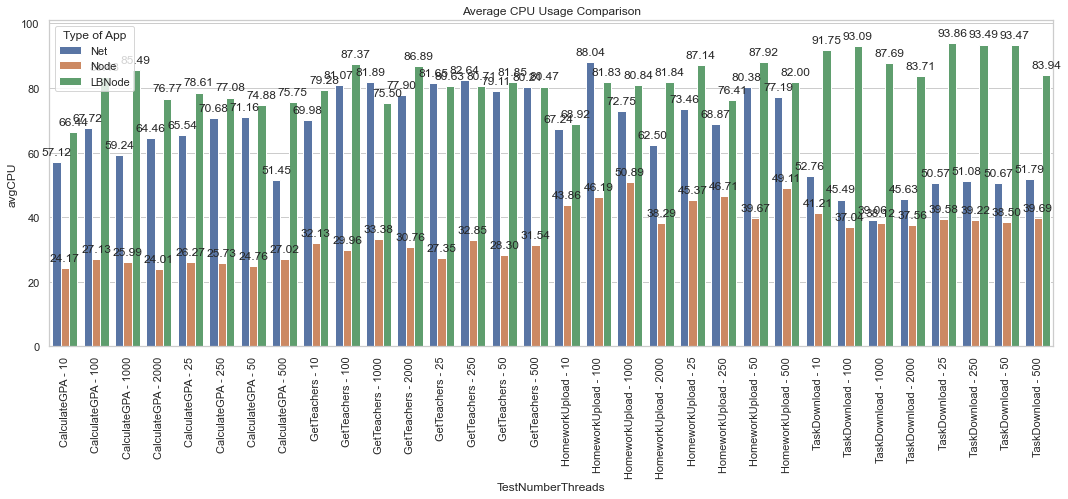

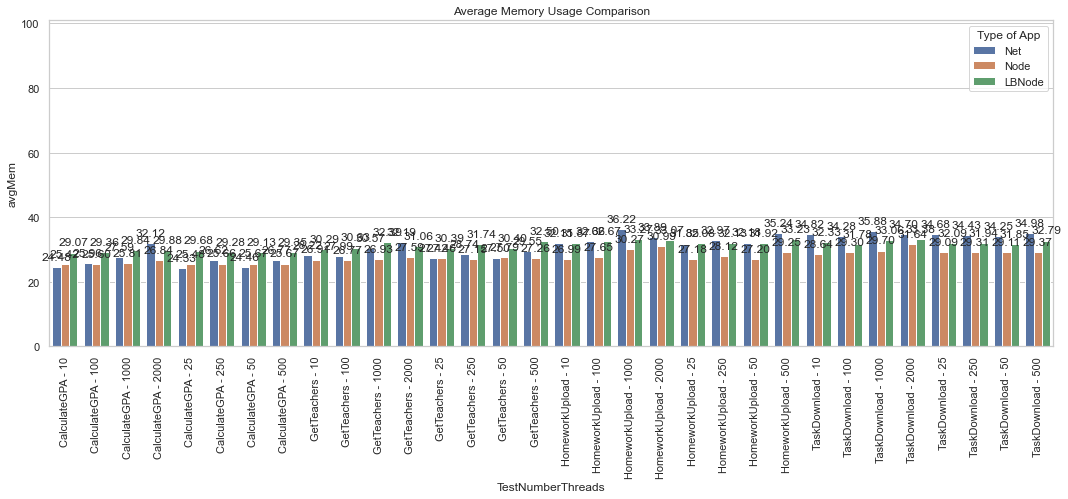

In [687]:
create_avg_comparison_graph_large(results_df)
create_avg_comparison_graph_large(results_df, False)

### Compare latency

In [688]:
def create_latency_dataframe(dataframe):
    # Create an empty dataframe to store the average latency
    latency_df = pd.DataFrame(columns=["Test", "Number of Threads", "Average Latency", "Min Latency", "Max Latency", "Type of App"])

    # Iterate through the dataframes dictionary
    for key, (df, properties) in dataframes.items():
        if properties["TypeOfReport"] == "AggregateReport":
            # Calculate the average latency
            avg_latency = df["Latency"].mean()
            min_latency = df["Latency"].min()
            max_latency = df["Latency"].max()

            # Create a new row for the average latency and add it to the latency dataframe
            new_row = {
                "Test": properties["NameOfTest"],
                "Number of Threads": properties["NumberOfThreads"],
                "Average Latency": avg_latency,
                "Min Latency": min_latency,
                "Max Latency": max_latency,
                "Type of App": properties["App"]
            }
            latency_df = latency_df.append(new_row, ignore_index=True)

    return latency_df


In [689]:
latency_df = create_latency_dataframe(dataframes)
display(latency_df)

,Test,Number of Threads,Average Latency,Min Latency,Max Latency,Type of App
0,CalculateGPA,1000,1270.641438,13,14000,Net
1,GetTeachers,1000,1344.533239,21,26209,Net
2,HomeworkUpload,1000,1960.602909,34,4551,Net
3,TaskDownload,1000,1617.243207,404,4440,Net
4,CalculateGPA,100,111.392881,46,993,Net
5,GetTeachers,100,131.581541,18,1280,Net
6,HomeworkUpload,100,202.236537,36,1286,Net
7,TaskDownload,100,130.973084,10,1330,Net
8,CalculateGPA,10,16.637200,7,743,Net
9,GetTeachers,10,19.367229,9,802,Net


In [690]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_latency_comparison_graphs(latency_df, test_name, type_of_latency):
    # Filter the latency dataframe for the specified test name
    filtered_df = latency_df[latency_df['Test'] == test_name]

    # Convert the 'Number of Threads' column to numeric type
    filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


    # Set the plot style
    sns.set(style="whitegrid")

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    ax = sns.pointplot(x='Number of Threads', y=type_of_latency, hue='Type of App', data=filtered_df, ci=None)

    # Set the axis labels and title
    ax.set_xlabel("Liczba użytkowników")
    if type_of_latency == "Average Latency":
        ax.set_ylabel("Średni czas odpowiedzi")
        ax.set_title(f"Średni czas odpowiedzi dla testu {test_name}")
    elif type_of_latency == "Min Latency":
        ax.set_ylabel("Minimalny czas odpowiedzi")
        ax.set_title(f"Minimalny czas odpowiedzi dla testu {test_name}")
    elif type_of_latency == "Max Latency":
        ax.set_ylabel("Maksymalny czas odpowiedzi")
        ax.set_title(f"Maksymalny czas odpowiedzi dla testu {test_name}")

    # Display the value of each bar on top
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Show the legend
    ax.legend(title="Aplikacja")

    # Show the plot
    plt.show()


C:\Users\neros\AppData\Local\Temp/ipykernel_3676/796464789.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


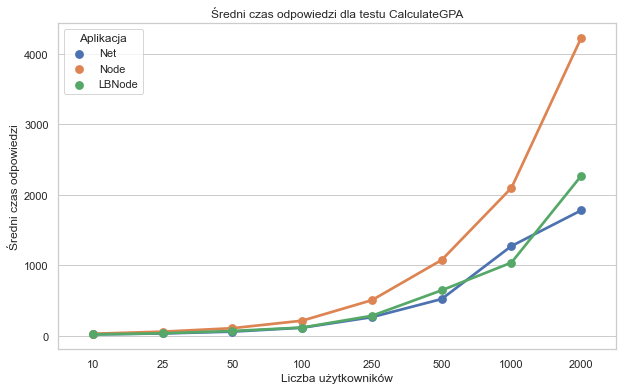

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/796464789.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


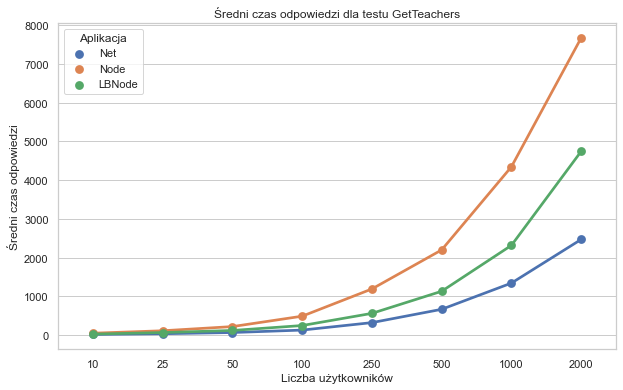

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/796464789.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


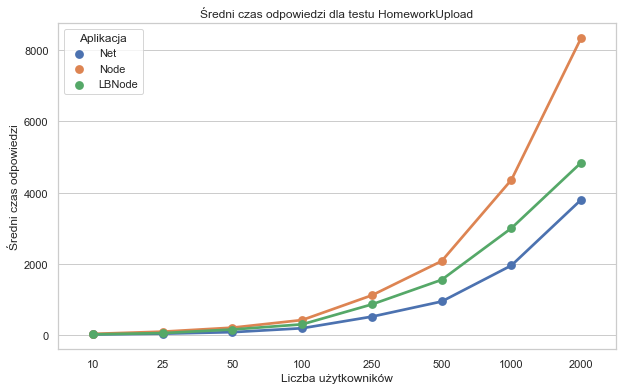

C:\Users\neros\AppData\Local\Temp/ipykernel_3676/796464789.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number of Threads'] = pd.to_numeric(filtered_df['Number of Threads'])


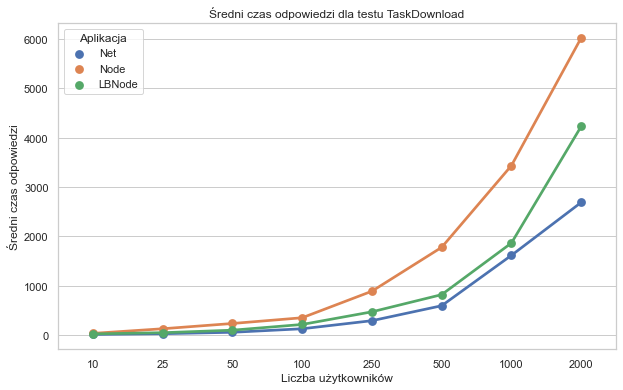

In [691]:
#"Average Latency" "Min Latency" "Max Latency",
latency_type = "Average Latency"
create_latency_comparison_graphs(latency_df, name_of_test[0], latency_type)
create_latency_comparison_graphs(latency_df, name_of_test[1], latency_type)
create_latency_comparison_graphs(latency_df, name_of_test[2], latency_type)
create_latency_comparison_graphs(latency_df, name_of_test[3], latency_type)

In [692]:
def create_latency_comparison_graph(latency_df, type_of_latency):
    # Filter the latency dataframe for the specified test name
    latency_df['TestNumberThreads'] = latency_df['Test'] + " - " + latency_df['Number of Threads'].astype(str)
    # Set the plot style
    sns.set(style="whitegrid")

    # Define the order of the Type of App values
    type_order = ['Net', 'Node', 'LBNode']

    # Create a bar plot
    plt.figure(figsize=(18, 6))
    ax = sns.barplot(x='TestNumberThreads', y=type_of_latency, hue='Type of App', data=latency_df,
                     dodge=True, ci=None, order=latency_df['TestNumberThreads'].unique(), hue_order=type_order)

    # Set the axis labels and title
    ax.set_xlabel("Number of Threads")
    ax.set_ylabel(type_of_latency)
    ax.set_title(f"Latency Comparison - {type_of_latency}")

    # Display the value of each bar on top
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)

    # Show the legend
    ax.legend(title="Type of App")

    # Show the plot
    plt.show()

    


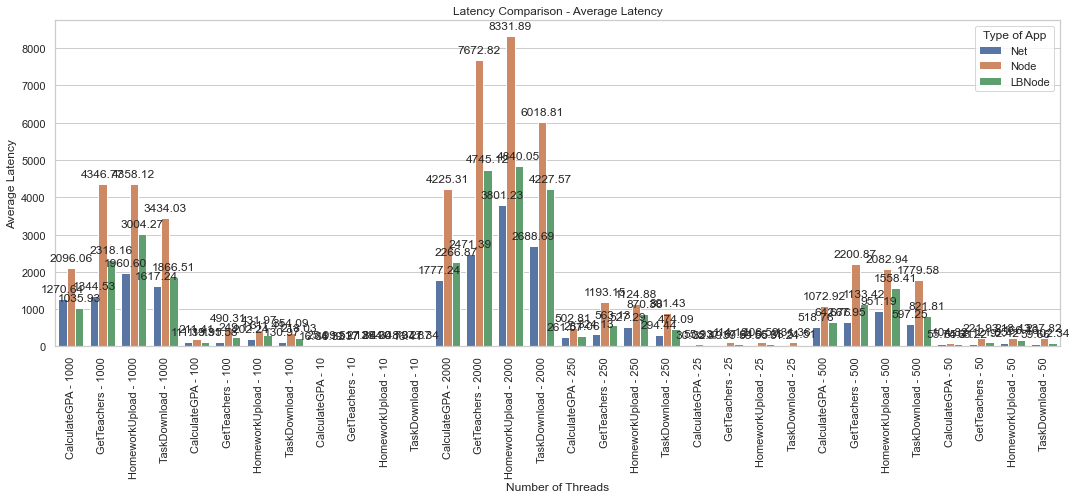

In [694]:
create_latency_comparison_graph(latency_df, "Average Latency")

In [695]:
def create_avg_values_table(latency_df, name_of_column):
    # Calculate average latency for each type of app and test
    filtered_df = latency_df.groupby(['Type of App', 'Test'])[name_of_column].mean().reset_index()

    # Pivot the DataFrame to create the desired table structure
    table = filtered_df.pivot(index='Type of App', columns='Test', values=name_of_column)

    # Add a column for the average of each row
    table['średnia'] = table.mean(axis=1)

    return table

In [697]:
# Call the function to create the throughput table
table = create_avg_values_table(throughput_df, "Throughput")

# Display the resulting table
display(table)

Test,CalculateGPA,GetTeachers,HomeworkUpload,TaskDownload,średnia
Type of App,,,,,
LBNode,836.244882,436.654456,366.991633,429.804572,517.423886
Net,886.825101,726.969829,506.431478,430.270277,637.624171
Node,495.572862,250.069499,266.270862,282.992155,323.726344


In [701]:
# Call the function to create the cpu table
table = create_avg_values_table(results_df, "avgCPU")

# Display the resulting table
display(table)

Test,CalculateGPA,GetTeachers,HomeworkUpload,TaskDownload,średnia
Type of App,,,,,
LBNode,77.312492,81.586885,80.862844,90.127383,82.472401
Net,63.422412,79.305503,73.804325,48.379695,66.227984
Node,25.635007,30.785357,45.012472,38.865519,35.074589


In [703]:
# Call the function to create the mem table
table = create_avg_values_table(results_df, "avgMem")

# Display the resulting table
display(table)

Test,CalculateGPA,GetTeachers,HomeworkUpload,TaskDownload,średnia
Type of App,,,,,
LBNode,29.450182,31.174818,32.528980,32.403185,31.389291
Net,26.540379,29.020854,33.395649,34.752785,30.927417
Node,25.768696,27.233214,28.457269,29.520986,27.745041


In [696]:
# Call the function to create the average latency table
table = create_avg_values_table(latency_df, "Average Latency")
display(table)

Test,CalculateGPA,GetTeachers,HomeworkUpload,TaskDownload,średnia
Type of App,,,,,
LBNode,556.836802,1153.287495,1356.049211,973.649251,1009.955690
Net,505.254205,633.070475,951.800971,679.487992,692.403411
Node,1036.905219,2036.387200,2087.413626,1610.624926,1692.832743


In [698]:
stats = calculate_stats_by_app(throughput_df[throughput_df['Test'] == 'GetTeachers'], "Throughput")
display(stats.sort_values(by='Type of App'))

,mean,min,max,std
Type of App,,,,
LBNode,436.654456,356.265109,521.232057,60.180997
Net,726.969829,507.304786,846.231156,102.544147
Node,250.069499,194.718807,377.641991,60.211710


In [699]:
stats = calculate_stats_by_app(results_df[results_df['Test'] == 'CalculateGPA'], "avgMem")
display(stats.sort_values(by='Type of App'))

,mean,min,max,std
Type of App,,,,
LBNode,29.450182,29.071000,29.880778,0.312725
Net,26.540379,24.327444,32.117889,2.565435
Node,25.768696,25.418800,26.836111,0.448442


In [700]:
stats = calculate_stats_by_app(results_df[results_df['Test'] == 'TaskDownload'], "avgMem")
display(stats.sort_values(by='Type of App'))

,mean,min,max,std
Type of App,,,,
LBNode,32.403185,31.782667,33.381333,0.602931
Net,34.752785,34.252600,35.877444,0.521863
Node,29.520986,28.641300,31.641889,0.908359
